# Starbucks App Reward Program

This file only contains the steps and code for 1) Preprocessing and Combibing Multiple Datasets.

**Authors: Joel Ligma**            
<br>
**Date: July 2020**


**Context**
<br>

The goal of this project was to *predict customer responsiveness* to specific marketing efforts. One of the main challenges of this project was to generate a single dataset derived from 3 datasets and to prepare the data for later analysis. The data files used for this project were sourced from Kaggle:
https://www.kaggle.com/blacktile/starbucks-app-customer-reward-program-data

## Table of Contents
**1) Preprocessing and Combining Multiple Datasets** 
- Data Clearning
- Feature Engineering
- Merging/Concatenating/Joining
<br>

**2) Exploratory Data Analysis (EDA)**
- Summary Statistics
- Univariate Analysis
- Bivariate Analysis
<br>

**3) Data Preparation**
- Feature Correlation
- Dummy Coding
- Training, Validation and Test Split
- Scaling Data
<br>

**4) Model Building & Validation**
- Baseline Accuracy
- Random Forest Classifier
- Neural Network Classifier
- XGBoost Classifier
- Model Comparison
<br>

**5) Saving the Model**
- Saving the Best Performing Model for Future Deployment
<br>

**6) Conclusion**
- Business Implications and Recommendations

# 1) Combining Multple Datasets

In [2]:
# load imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MultiLabelBinarizer # awesome for multiple values in one cell
import csv # write csv file of the complete dataset
from datetime import date 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler # for scaling
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # model validation
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from sklearn.externals import joblib

C:\Users\joell\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
# Read in files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

## Examine Dataset One: Portfolio

In [4]:
portfolio.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


As specified in the source description, the **ID** column listed in the portfolio file refers to **Offer ID**.
<br>

Let's change the name of this column to **Offer ID**.

In [6]:
portfolio.rename(columns = {'id':'offer_id'},inplace=True)

Check for unique values in Offer Type and Channels. This is not necessarily important here because we only have 10 rows but will be useful for bigger datasets. Let's do it anyway.

In [7]:
print("offer_type unique values: {}".format(portfolio['offer_type'].unique()))

offer_type unique values: ['bogo' 'informational' 'discount']


In [8]:
# check for unique values/ combinations in list "channels"
unique_list = [] 
# loop through list      
for channels in portfolio.channels: 
    if channels not in unique_list: 
        unique_list.append(channels) 
        
# print unique combinations
for channels in unique_list: 
    print (channels) 

['email', 'mobile', 'social']
['web', 'email', 'mobile', 'social']
['web', 'email', 'mobile']
['web', 'email']


One can see that both features are not in an appropriate format for machine learning models. Thus, let's create new columns out of these 2 columns with the aim to separate the entries in each row. Subsequently, we will drop the old columns.

In [9]:
# separate the entires in the "channels" column and dummy code them
mlb = MultiLabelBinarizer()
channels_array = mlb.fit_transform(portfolio["channels"])
channels_df = pd.DataFrame(data=channels_array, columns=mlb.classes_)
# merge channels_df with portfolio again
portfolio = pd.concat([portfolio, channels_df], axis=1)

# also dummy code "offer_type" 
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])], axis=1)

# examine if it worked porperly
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [10]:
# quick comment: all missing data in "channels" were assigned a "0"

# drop "channels" and "offer_type" columns since they are now redundant
portfolio.drop("channels", axis=1, inplace=True)
portfolio.drop("offer_type", axis=1, inplace=True)

portfolio.head() # we keep offer_id to be able to merge the data sets later

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


As a result, the first dataset is now ready to be used for machine learning. The Offer ID column remains in its current state because it will be used to merge the datasets later on.

## Examine Dataset Two: Transcript

In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [12]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


According to the information given on Kaggle, **Person** refers to **Customer ID** so let's rename this column.

In [13]:
transcript.rename(columns = {'person': 'customer_id'}, inplace = True)

Next, the feature **Value** will be examined.

In [14]:
# check for unique values in "value" column
values_per_key = {}
for d in transcript.value:
    for k, v in d.items():
        values_per_key.setdefault(k, set()).add(v)
counts = {k: len(v) for k, v in values_per_key.items()}
counts

{'offer id': 10, 'amount': 5103, 'offer_id': 8, 'reward': 4}

Looks like the data for multiple columns ended up in this single column or the file didn't read in properly. In its current state the **Value** column contains information from 3 separate columns. This is based on the assumption that **Offer_ID** and **Offer ID** are the same column.

**My approach:**

- split the column into separate columns and store them into a new dataframe
- check values and then combine the two offer_id columns
- drop the old columns
- combine the two dataframes

In [15]:
# split the columns and create new dataframe with these columns
df = transcript["value"].apply(pd.Series)

# combine "offer_id" and "offer id" into a single columns based on NaNs and drop both afterwards
df["offer_id_new"] = df['offer_id'].fillna(df["offer id"])
df.drop(columns = 'offer_id', inplace = True )
df.drop(columns = 'offer id', inplace = True )

# combine the new column with the transcript dataframe again
transcript_1 = pd.concat([transcript, df], axis=1)

# change the "offer_id_new" column label to "offer_id"
transcript_1.rename(columns = {'offer_id_new': 'offer_id'}, inplace = True)

transcript_1.head(10)

,customer_id,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,NaN,NaN,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


Looks like it worked as intended. Next, let's drop the original **Value** column since it is now redundant.

In [16]:
transcript_1.drop(columns = "value", inplace=True)

Taking a closer look look at **Offer ID** and **Customer ID**. 

In [17]:
transcript_1.sort_values(['customer_id', "offer_id"]).head(10)

,customer_id,event,time,amount,reward,offer_id
247879,0009655768c64bdeb2e877511632db8f,offer received,576,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
258884,0009655768c64bdeb2e877511632db8f,offer completed,576,NaN,2.0,2906b810c7d4411798c6938adc9daaa5
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
153401,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4


Many customers received multiple offers (**Offer IDs**) and each step along the process was recorded in this dataset.
<br>

**Process:** Offer Received -> Offer Viewed -> Offer Completed
<br>

Not all customers act on these offers but some do. However, let's assume a customer receives an offer, views it and then completes the offer by purchasing something, using the offer sent to him. In this case, all 3 steps are included in this dataset which poses a problem. The problem is that when e.g. a customer completes a purchase, we know that he/she received and viewed an offer. We do not need any additional entries to know this. Same applies to when a customer simply viewed an offer. In this case, we also know that the customer must have received an offer. Once again, both steps are recorded in the dataset.
<br>

Solution: Drop redundant rows for each **Customer IDs** and **Offer IDs**.
<br>

Approach: 
- Reorder the **transcript_1** dataframe
- set **Customer ID** and **Offer ID** as index
- rename **Amount** to **Transaction Amount** because once an amount is recorded a transaction has been performed
- encode the **Event** column
- sort values by **Customer ID**, **Offer ID** and **Event** (**Event** in decending order
- store the sorted dataset in a new dataframe
- remove any duplicate **Offer IDs** per **Customer ID** and keep first occurance which retains the most recent progress step per customer per Offer ID in the dataframe since we sorted the encoded **Event** feature in decending order.


In [18]:
# reorder the df
transcript_1 = transcript_1[["customer_id","offer_id", "event", "amount", "reward","time"]]

# set Customer ID and Offer ID as multi-index  
transcript_1 = transcript_1.set_index(["customer_id", "offer_id"])

# rename the Amount column to Transaction Amount which already implies that a transaction was conducted so the transaction label
# in the Events column can be dropped later
transcript_1.rename(columns={"amount": "transaction_amount"},inplace=True)

transcript_1.sort_values(['customer_id', "offer_id", "event"]).head(20) 

event  \
customer_id                      offer_id                                            
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  offer completed   
                                 2906b810c7d4411798c6938adc9daaa5   offer received   
                                 3f207df678b143eea3cee63160fa8bed   offer received   
                                 3f207df678b143eea3cee63160fa8bed     offer viewed   
                                 5a8bc65990b245e5a138643cd4eb9837   offer received   
                                 5a8bc65990b245e5a138643cd4eb9837     offer viewed   
                                 f19421c1d4aa40978ebb69ca19b0e20d  offer completed   
                                 f19421c1d4aa40978ebb69ca19b0e20d   offer received   
                                 f19421c1d4aa40978ebb69ca19b0e20d     offer viewed   
                                 fafdcd668e3743c1bb461111dcafc2a4  offer completed   
                                 fafdcd668e3743c1bb461111dcafc2a4   offer received   
                                 fafdcd668e3743c1bb461111dcafc2a4     offer viewed   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   
                                 NaN                                   transaction   

                                                                   transaction_amount  \
customer_id                      offer_id                                               
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 3f207df678b143eea3cee63160fa8bed                 NaN   
                                 3f207df678b143eea3cee63160fa8bed                 NaN   
                                 5a8bc65990b245e5a138643cd4eb9837                 NaN   
                                 5a8bc65990b245e5a138643cd4eb9837                 NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d                 NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d                 NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 NaN                                            22.16   
                                 NaN                                             8.57   
                                 NaN                                            14.11   
                                 NaN                                            13.56   
                                 NaN                                            10.27   
                                 NaN                                            12.36   
                                 NaN                                            28.16   
                                 NaN                                            18.41   

                                                                   reward  \
customer_id                      offer_id                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     2

Label encode the **Event** feature from 1 - 4 which is needed to sort in descending order later, drop the old column and store the sorted data in a new dataframe.

In [19]:
# label encode the Event feature
transcript_1['event_new'] = transcript_1['event'].map({'offer completed':4,
                                                       'offer viewed':3, 
                                                       "offer received":2, 
                                                       "transaction":1})
# drop the original Event feature
transcript_1.drop(columns="event", inplace=True)

# sort values by Customer ID, Offer ID and Event New in ascending order and store it as dataframe
transcript_2 = transcript_1.sort_values(["customer_id","offer_id", "event_new"], ascending=False)
transcript_2.head(30)

transaction_amount  \
customer_id                      offer_id                                               
ffff82501cea40309d5fdd7edcca4a07 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4                 NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                 NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                 NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 2906b810c7d4411798c6938adc9daaa5                 NaN   
                                 0b1e1539f2cc45b7b9fa7c272da2e1d7                 NaN   
                                 0b1e1539f2cc45b7b9fa7c272da2e1d7                 NaN   
                                 0b1e1539f2cc45b7b9fa7c272da2e1d7                 NaN   
                                 NaN                                            16.06   
                                 NaN                                             7.18   
                                 NaN                                             9.12   
                                 NaN                                            22.88   
                                 NaN                                            15.23   
                                 NaN                                            18.08   
                                 NaN                                            23.32   
                                 NaN                                            16.86   
                                 NaN                                            15.57   
                                 NaN                                            17.55   
                                 NaN                                            13.17   
                                 NaN                                             7.79   

                                                                   reward  \
customer_id                      offer_id                                   
ffff82501cea40309d5fdd7edcca4a07 fafdcd668e3743c1bb461111dcafc2a4     2.0   
                                 fafdcd668e3743c1bb461111dcafc2a4     NaN   
                                 fafdcd668e3743c1bb461111dcafc2a4     NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     5.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN   
                                 2906b810c7d4411798c6938adc9daaa5     2.0   
                                 2906b810c7d4411798c6938adc9daaa5     2.0   
                                 2906b810c7d4411798c6938adc9daaa5     2.0   
                                 2906b810c7d4411798c6938adc9daaa5     NaN   
                                 2906b810c7d4411798c6938adc9daaa5     NaN   
                                 2906b810c7d4411798c6938adc9daaa5     NaN   
                                 2906b810c7d4411798c6938adc9daaa5     NaN   
                                 2906b810c7d4411798c6938adc9daa

In [20]:
# drop index Offer ID if there are any duplicates
# yes, some information will be lost but the majority of information will be retained. Why lost? Because some customers received
# the same Offer ID multiple times
transcript_2 = transcript_2.loc[~transcript_2.index.duplicated(keep='first')]

# let's rename the Event New feature
transcript_2.rename(columns= {"event_new": "event"}, inplace=True)

# let's take a look at the processed transcript df
transcript_2["event"].value_counts() # 4: Offer Completed 3: Offer Viewed 2: Offer Received 1: Transaction

4    28996
3    24675
1    16578
2     9617
Name: event, dtype: int64

Let's convert **Offer ID** back to column.

In [21]:
transcript_2.reset_index(level=['offer_id'], inplace=True)
transcript_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79866 entries, ffff82501cea40309d5fdd7edcca4a07 to 0009655768c64bdeb2e877511632db8f
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   offer_id            63288 non-null  object 
 1   transaction_amount  16578 non-null  float64
 2   reward              28996 non-null  float64
 3   time                79866 non-null  int64  
 4   event               79866 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 3.7+ MB


Further, as described on Kaggle, the **Time** column is measured in hours:
"time in hours since the start of the test. The data begins at time t=0." Let's inspect this feature below.

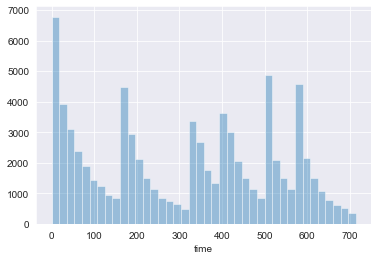

In [22]:
sns.set_style('darkgrid')
sns.distplot(transcript_2["time"],kde=False)

One can see that in many instances the number of hours is quite high. Let's convert the measurement from hours to days instead.

In [23]:
transcript_2['days_since_test'] = transcript_2['time'] // 24 # divison without remainders
transcript_2.drop(columns = 'time', inplace = True)

The second dataset is now processed and ready for merging to create a complete dataset.

## Examine Dataset Three: Profile

In [24]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [25]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


As written on Kaggle, **ID** refers to **Customer ID** and therefore we will rename the column.

In [26]:
profile.rename(columns = {'id':'customer_id'},inplace=True)

One can observe that the profile dataset contains missing values for **Gender** and **Income**. In fact, they show the exact same total number of missing values. We have 2175 missing entries for **Ggender**. We can see in the output of .info() that **Income** has the same number of missing values. I suspect that for these two columns there are missing data in the same rows. Let's check and then drop these rows.

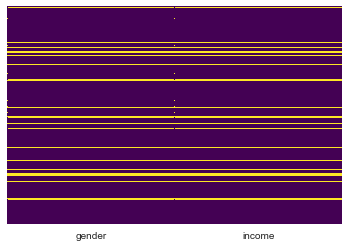

In [27]:
# for a closer comparison
gender_income = profile[["gender", "income"]].copy()
sns.heatmap(gender_income.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [28]:
profile.dropna(inplace=True)
profile.reset_index(inplace=True,drop=True) # resetting the index due to dropped values
profile.isna().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
dtype: int64

No missing values left.

In [29]:
profile["gender"].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Upon further examination of the **Gender** feature, one can see that 212 customers did not want to give an answer or specify their gender. Let's remove these entries because this will not yield useful insights for our analysis later on. As last step for the **Gender** feature, the column will be dummy-coded and the original column dropped.

In [30]:
profile = profile[profile.gender != 'O']
profile['male'] = profile['gender'].map({'M':1,'F':0}) # 1 is male, 0 is female
profile[['gender','male']] # to check if it worked proprely

,gender,male
0,F,0
1,F,0
2,M,1
3,M,1
4,M,1
...,...,...
14820,F,0
14821,M,1
14822,M,1
14823,F,0


In [31]:
# now we can drop the original column
profile.drop(columns = 'gender', inplace = True) 

The feature **Became Member On** is supposed to be in datetime format. However, this is not the case here. Moreover, in order to be able to use this feature in any machine learning model, it must be feature engineered. 

My approach:

First, convert the current column format (int) to datetime and then calculate the total number of membership days per customer. Lastly, I will drop the old column.


In [32]:
# convert column to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")

In [33]:
# let's see the timeframe the customer data was collected
print(profile["became_member_on"].min(),profile["became_member_on"].max()) 

2013-07-29 00:00:00 2018-07-26 00:00:00


The customer data was collected between July 29th, 2013 and July 26th, 2018

In [34]:
# create a function to convert the column into total number of days
def total_days_converter(start_date, end_date= profile["became_member_on"].max()):
    for date in start_date:
        days = (end_date-start_date)
        return days 

In [35]:
# apply function to perform the conversion
profile["membership_days"] = total_days_converter(profile["became_member_on"])
profile.drop(columns="became_member_on", inplace=True)
profile["membership_days"].head()

0   376 days
1   443 days
2    91 days
3   167 days
4   257 days
Name: membership_days, dtype: timedelta64[ns]

In [36]:
# since we are only interested in the total number of days we can extract the number of days and convert it to integer format
profile['membership_days'] = pd.to_numeric(profile['membership_days'].dt.days, downcast='integer')

The third and final dataset is ready to be used for merging. The **Customer ID** column remains in its current state because it will be used to merge the datasets next. However, this dataset is not yet suitable for machine learning because the 3 datetime columns need more processing which will be conducted later.

## Merging the Three Datasets into a Complete Dataset

**Step 1:** Let's start by merging the cleaned **Transcript** dataset with the **Profile** dataset on **Customer ID**.

In [37]:
# we merge them with "how = 'outer'" to retain all rows even if there is not a match on "customer_id" 
step1 = pd.merge(transcript_2, profile, on="customer_id", how="outer")
step1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79866 entries, 0 to 79865
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         79866 non-null  object 
 1   offer_id            63288 non-null  object 
 2   transaction_amount  16578 non-null  float64
 3   reward              28996 non-null  float64
 4   event               79866 non-null  int64  
 5   days_since_test     79866 non-null  int64  
 6   age                 68741 non-null  float64
 7   income              68741 non-null  float64
 8   male                68741 non-null  float64
 9   membership_days     68741 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 6.7+ MB


**Step 2:** Let's merge the **Step1** dataset with the **Portfolio** dataset on **Offer ID** to create the complete dataset.

In [38]:
step2 = pd.merge(step1, portfolio, on="offer_id", how="outer") # outer to avoid dropping NaNs or no match on Offer ID
step2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79866 entries, 0 to 79865
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         79866 non-null  object 
 1   offer_id            63288 non-null  object 
 2   transaction_amount  16578 non-null  float64
 3   reward_x            28996 non-null  float64
 4   event               79866 non-null  int64  
 5   days_since_test     79866 non-null  int64  
 6   age                 68741 non-null  float64
 7   income              68741 non-null  float64
 8   male                68741 non-null  float64
 9   membership_days     68741 non-null  float64
 10  reward_y            63288 non-null  float64
 11  difficulty          63288 non-null  float64
 12  duration            63288 non-null  float64
 13  email               63288 non-null  float64
 14  mobile              63288 non-null  float64
 15  social              63288 non-null  float64
 16  web 

# Preparing the Complete Dataset

Finally, after merging the datasets into the complete dataset we have to do some last preprocessing steps before we can start with our analysis.
<br>

- drop **Customer ID** and **Offer ID** columns since we are now done with merging datasets and don't need them anymore
- fill NaNs in **Transaction Amount**, **Difficulty**, **Duration, **Email**, **Mobile**, **Social**, **Web**, **Bogo**, **Discount** and **Informational** with 0s
- examine if **reward_x** and **reward_y** are identical and then drop one, fill the remaining NaNs with 0 and rename the feature

In [39]:
step2.drop(columns=["customer_id", "offer_id"], inplace=True)

In [40]:
# fill NaNs in with 0s 
step2["transaction_amount"].fillna(value=0, inplace=True)
step2["difficulty"].fillna(value=0, inplace=True)
step2["duration"].fillna(value=0, inplace=True)
step2["email"].fillna(value=0, inplace=True)
step2["mobile"].fillna(value=0, inplace=True)
step2["social"].fillna(value=0, inplace=True)
step2["web"].fillna(value=0, inplace=True)
step2["bogo"].fillna(value=0, inplace=True)
step2["discount"].fillna(value=0, inplace=True)
step2["informational"].fillna(value=0, inplace=True)

In [41]:
# check if reward_x values are all in reward_y
step2["reward_x"].isin(step2["reward_y"]).all()

True

In [42]:
# this means we can drop reward_x, rename reward_y to reward and fill any missing values with 0
step2.drop(columns="reward_x", inplace=True)
step2.rename(columns={"reward_y" : "reward"},inplace=True)
step2["reward"].fillna(value=0, inplace=True)

Let's check for any additional missing values. If there are still find missing data we will drop them.

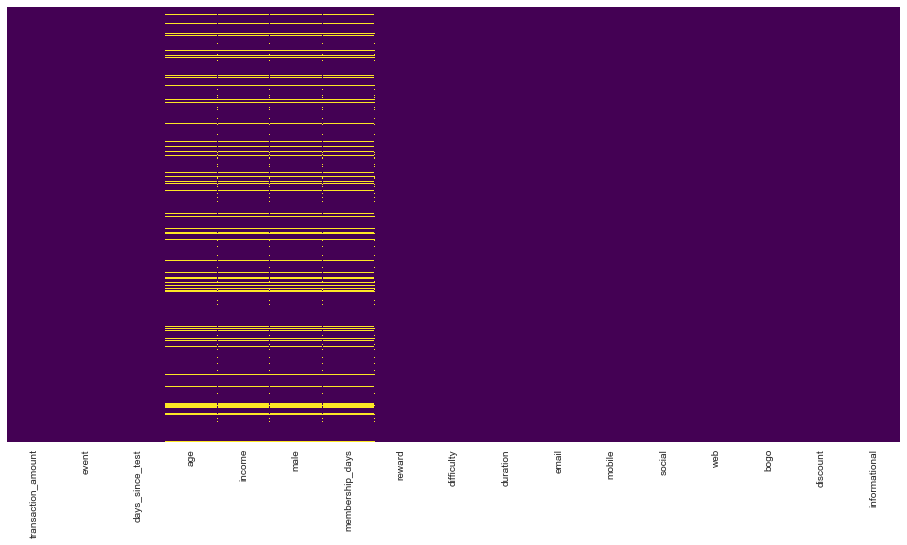

In [43]:
plt.figure(figsize=(16,8))
sns.heatmap(step2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [44]:
# drop NaNs
step2.dropna(inplace=True)
step2.reset_index(inplace=True,drop=True) # resetting the index caused by dropped values
step2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68741 entries, 0 to 68740
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_amount  68741 non-null  float64
 1   event               68741 non-null  int64  
 2   days_since_test     68741 non-null  int64  
 3   age                 68741 non-null  float64
 4   income              68741 non-null  float64
 5   male                68741 non-null  float64
 6   membership_days     68741 non-null  float64
 7   reward              68741 non-null  float64
 8   difficulty          68741 non-null  float64
 9   duration            68741 non-null  float64
 10  email               68741 non-null  float64
 11  mobile              68741 non-null  float64
 12  social              68741 non-null  float64
 13  web                 68741 non-null  float64
 14  bogo                68741 non-null  float64
 15  discount            68741 non-null  float64
 16  info

No missing data left. The final dataset contains 68,741 observations and 17 columns. Let's save it as a csv file and begin with our analysis.

In [ ]:
# Write csv file of the step2 data set 
step2.to_csv("starbucks.csv")

# End of 1) Preprocessing and Combining Multiple Datasets